Untungnya library keras menyediakan **ImageDataGenerator** yang dapat mempermudah kita dalam memproses data untuk model kita. 

Nah tanpa menunda lagi, kita akan langsung latihan membuat model untuk memprediksi dataset chessman yang telah disebutkan sebelumnya. Pada Google Colab ketik kode berikut untuk mengunduh data.

In [1]:
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip \
  -O /tmp/Chessman-image-dataset.zip

--2021-09-20 13:55:10--  https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip [following]
--2021-09-20 13:55:10--  https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60684125 (58M) [application/zip]
Saving to: ‘/tmp/Chessman-image-dataset.zip’

/tmp/Chessman-image 100%[===================>]  57.87M   157MB/s    in 

Selanjutnya kita perlu melakukan ekstraksi terhadap dataset yang kita unduh karena dataset dalam bentuk file zip.

In [2]:
import os
import zipfile

local_zip = '/tmp/Chessman-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Gunakan fungsi listdir dari kelas os untuk melihat direktori yang terdapat pada dataset. Dapat kita lihat bahwa terdapat 6 buah direktori pada dataset. Setiap direktori berisi gambar pion catur sesua dengan nama direktorinya.

In [4]:
os.listdir('/tmp/Chessman-image-dataset/Chess')

['Rook', 'Queen', 'Pawn', 'Knight', 'Bishop', 'King']

Selanjutnya kita perlu melihat berapa banyak gambar pada setiap direktori. Dari output dapat dilihat bahwa jumlah sampel pada tiap direktori berbeda. Perlu diperhatikan juga dataset ini berukuran sangat kecil sehingga performa dari model mungkin tidak akan terlalu baik. Kita akan mencoba menggunakan augmentasi gambar untuk mengatasi masalah ini.

In [6]:
print('total Pawn images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Pawn')))
print('total King images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/King')))
print('total Knight images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Knight')))

total Pawn images : 107
total King images : 76
total Knight images : 106


Kita dapat melihat contoh dari sebuah gambar pada dataset dengan menjalankan kode di bawah.

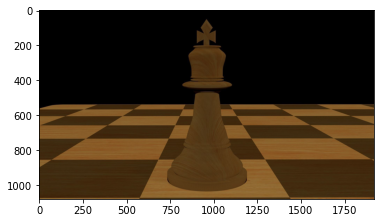

In [8]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = image.load_img('/tmp/Chessman-image-dataset/Chess/King/00000145.png')
imgplot = plt.imshow(img)

Selanjutnya kita impor `ImageDataGenerator` dan aplikasikan augmentasi gambar pada dataset kita. Perhatikan bahwa ada parameter yaitu *validation split*. Parameter ini akan dijelaskan pada paragraf berikutnya.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('/tmp/Chessman-image-dataset/Chess')
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest',
                                   validation_split = 0.1) # set validation split

Dataset yang kita miliki hanya terdiri dari 1 buah direktori dan tidak terbagi menjadi direktori training dan testing. Tapi tenang, dengan `ImageDataGenerator` kita tidak perlu susah payah membagi direktori secara manual, cukup dengan menggunakan parameter `validation_split` yang disebut pada paragraf sebelumnya. Dengan parameter tersebut, kita hanya cukup memberi tahu `ImageDataGenerator` mana data untuk training dan mana data untuk testing dengan menambahkan parameter subset dengan nilai *training* atau *validation*.

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 8,
    class_mode = 'categorical',
    subset = 'training' # set as training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size = (150, 150),
    batch_size = 16,
    class_mode = 'categorical',
    subset = 'validation' # set as validation data
)

Found 499 images belonging to 6 classes.
Found 52 images belonging to 6 classes.


Selanjutnya, kita buat arsitektur dari model kita. Untuk model ini kita menggunakan 3 lapis **convolution** dan 2 **hidden layer** dengan 512 dan 256 buah **unit perseptron**.

In [12]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # Flatten the result to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(6, activation='softmax')
])

Setelah arsitektur dibuat, tentukan `optimizer` dan `loss` yang akan digunakan model

In [13]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Terakhir, panggil fungsi `fit` untuk melatih model kita.

In [15]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    verbose=2)

# Dapat dilihat bahwa akurasi untuk data validasi yang dihasilkan berada di sekitar 0.5. 

Epoch 1/50
63/63 - 43s - loss: 3.0619 - accuracy: 0.1743 - val_loss: 1.7859 - val_accuracy: 0.1923
Epoch 2/50
63/63 - 11s - loss: 1.7863 - accuracy: 0.1703 - val_loss: 1.7825 - val_accuracy: 0.1923
Epoch 3/50
63/63 - 11s - loss: 1.7826 - accuracy: 0.2024 - val_loss: 1.7888 - val_accuracy: 0.2115
Epoch 4/50
63/63 - 11s - loss: 1.7611 - accuracy: 0.1944 - val_loss: 1.7742 - val_accuracy: 0.2308
Epoch 5/50
63/63 - 11s - loss: 1.7254 - accuracy: 0.2565 - val_loss: 1.7706 - val_accuracy: 0.2115
Epoch 6/50
63/63 - 11s - loss: 1.6969 - accuracy: 0.2685 - val_loss: 1.7879 - val_accuracy: 0.2308
Epoch 7/50
63/63 - 11s - loss: 1.6737 - accuracy: 0.2966 - val_loss: 1.7786 - val_accuracy: 0.2115
Epoch 8/50
63/63 - 11s - loss: 1.6196 - accuracy: 0.2946 - val_loss: 1.6976 - val_accuracy: 0.2500
Epoch 9/50
63/63 - 11s - loss: 1.6048 - accuracy: 0.3447 - val_loss: 1.8864 - val_accuracy: 0.2115
Epoch 10/50
63/63 - 11s - loss: 1.5612 - accuracy: 0.3607 - val_loss: 1.8321 - val_accuracy: 0.2308
Epoch 11/

Anda juga dapat membuat plot akurasi dari model menggunakan kode berikut.

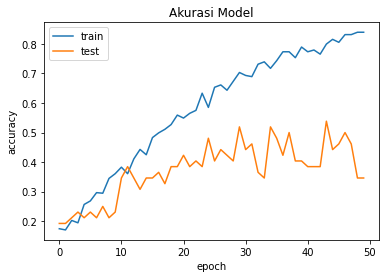

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Jika kode di atas dijalankan, maka tampilannya seperti di bawah ini :

Untuk membuat plot loss Anda cukup menjalankan kode berikut.

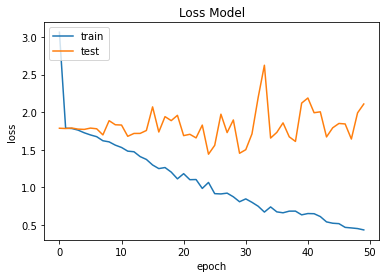

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Selamat, Anda berhasil mengembangkan model untuk mengklasifikasikan dataset yang sangat variatif. Akurasi yang didapat sekitar 50% di mana model akan membuat sekitar 50 persen prediksi yang salah. 

# Pada submodul selanjutnya kita akan belajar mengenai transfer learning dan melihat bagaimana teknik itu meningkatkan akurasi dari model ini.